In [27]:
import pandas as pd
import os
import time
import requests
import json
import csv
from tqdm import tqdm
import html
import tweepy
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy

Open Dataset

In [28]:
data = pd.read_csv("TweetsElonMusk.csv", encoding='utf-8')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12563 entries, 0 to 12562
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               12563 non-null  object 
 1   conversation_id  12563 non-null  float64
 2   created_at       12562 non-null  object 
 3   date             12562 non-null  object 
 4   time             12562 non-null  object 
 5   timezone         12562 non-null  float64
 6   user_id          12562 non-null  float64
 7   username         12562 non-null  object 
 8   name             12562 non-null  object 
 9   place            0 non-null      float64
 10  tweet            12562 non-null  object 
 11  language         12562 non-null  object 
 12  mentions         12562 non-null  object 
 13  urls             12562 non-null  object 
 14  photos           12562 non-null  object 
 15  replies_count    12562 non-null  float64
 16  retweets_count   12562 non-null  float64
 17  likes_count 

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1.38127E+18,1.381000e+18,2021-04-11 18:50:33 EEST,4/11/21,18:50:33,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vincent13031925', 'name': 'V...",NaN,NaN,NaN,NaN
1,1.38127E+18,1.372440e+18,2021-04-11 18:48:58 EEST,4/11/21,18:48:58,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1.38126E+18,1.381230e+18,2021-04-11 17:49:38 EEST,4/11/21,17:49:38,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'agnostoxxx', 'name': 'Shrubb...",NaN,NaN,NaN,NaN
3,1.38122E+18,1.381220e+18,2021-04-11 15:23:49 EEST,4/11/21,15:23:49,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1.38113E+18,1.381080e+18,2021-04-11 09:18:47 EEST,4/11/21,9:18:47,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'itsALLrisky', 'name': '💸💸💸',...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12558,1.38224E+18,1.382190e+18,2021-04-14 10:50:45 EEST,4/14/21,10:50:45,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'PPathole', 'name': 'Pranay P...",NaN,NaN,NaN,NaN
12559,1.38224E+18,1.382190e+18,2021-04-14 10:48:25 EEST,4/14/21,10:48:25,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'PPathole', 'name': 'Pranay P...",NaN,NaN,NaN,NaN
12560,1.38213E+18,1.382050e+18,2021-04-14 03:41:45 EEST,4/14/21,3:41:45,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Erdayastronaut', 'name': 'Ev...",NaN,NaN,NaN,NaN
12561,1.38205E+18,1.382050e+18,2021-04-13 22:25:11 EEST,4/13/21,22:25:11,300.0,44196397.0,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Erdayastronaut', 'name': 'Ev...",NaN,NaN,NaN,NaN


Clean Data

In [29]:
data=data[['date','tweet']]

#delete the duplicates by dropping them
data = data.drop_duplicates("tweet",keep="first")
data.reset_index(inplace=True)
data.drop(columns=['index'],inplace=True)
import re
import string
def clean(text):
    text1 = re.sub(r'#\w+ ?', "", str(text)) #Removes hashtags
    text1 = re.sub(r'@\w+ ?',"",text1) #Removes usernames 
    text1 = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text1) #Removes links 
    text1 = re.sub('[0-9]+', "", text1) #Removes numbers 
    text1 = " ".join(text1.split())
    text1 = "".join([char for char in text1 if char not in string.punctuation]) #Removes punctuations
    text1 = text1.replace('\n',"") #Removes escape sequences
    return text1
data['Tweets_clean'] = data['tweet'].apply(lambda x:clean(x))


stop_words = set(stopwords.words("english"))
def Clean_Words(text):
   text1 = re.split('\W+', text) #Tokenization
   text1 = [word for word in text1 if word not in stop_words] #removing stop words
   text1 = [PorterStemmer().stem(word) for word in text1]#removing suffixes
   text1 = [WordNetLemmatizer().lemmatize(word) for word in text1]#Lemmatization
   return text1

data['Tweets_clean_more'] = data['Tweets_clean'].apply(lambda x:Clean_Words(x))
data

,date,tweet,Tweets_clean,Tweets_clean_more
0,4/11/21,@vincent13031925 For now. Costs are decreasing...,For now Costs are decreasing rapidly,"[for, cost, decreas, rapidli]"
1,4/11/21,Love this beautiful shot,Love this beautiful shot,"[love, beauti, shot]"
2,4/11/21,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,Trust the shrub,"[trust, shrub]"
3,4/11/21,The art In Cyberpunk is incredible,The art In Cyberpunk is incredible,"[the, art, in, cyberpunk, incred]"
4,4/11/21,@itsALLrisky 🤣🤣,🤣🤣,"[, ]"
...,...,...,...,...
12500,4/14/21,@PPathole @SpaceX @Tesla That was my night job...,That was my night job Day job was working on r...,"[that, night, job, day, job, work, rutheniumta..."
12501,4/14/21,@PPathole @SpaceX @Tesla True. Ancient times …...,True Ancient times … Had to flip CPU registers...,"[true, ancient, time, had, flip, cpu, regist, ..."
12502,4/14/21,@Erdayastronaut @Tesla Absolutely,Absolutely,[absolut]
12503,4/13/21,@Erdayastronaut @Tesla Tesla is building up co...,Tesla is building up collision repair capabili...,"[tesla, build, collis, repair, capabl, help, a..."


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12505 entries, 0 to 12504
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               12504 non-null  object
 1   tweet              12504 non-null  object
 2   Tweets_clean       12505 non-null  object
 3   Tweets_clean_more  12505 non-null  object
dtypes: object(4)
memory usage: 390.9+ KB


In [31]:
data['Tweets_clean_more'] = data['Tweets_clean_more'].apply(lambda x:clean(x))
data.head()


,date,tweet,Tweets_clean,Tweets_clean_more
0,4/11/21,@vincent13031925 For now. Costs are decreasing...,For now Costs are decreasing rapidly,for cost decreas rapidli
1,4/11/21,Love this beautiful shot,Love this beautiful shot,love beauti shot
2,4/11/21,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,Trust the shrub,trust shrub
3,4/11/21,The art In Cyberpunk is incredible,The art In Cyberpunk is incredible,the art in cyberpunk incred
4,4/11/21,@itsALLrisky 🤣🤣,🤣🤣,


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12505 entries, 0 to 12504
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               12504 non-null  object
 1   tweet              12504 non-null  object
 2   Tweets_clean       12505 non-null  object
 3   Tweets_clean_more  12505 non-null  object
dtypes: object(4)
memory usage: 390.9+ KB


Combine tweets with same date

In [46]:
df=data.groupby('date')['Tweets_clean_more'].apply(' '.join).reset_index()
df.loc[df['date'] =='4/11/21']

,date,Tweets_clean_more
1048,4/11/21,for cost decreas rapidli love beauti shot trus...


In [49]:
df.head()

,date,Tweets_clean_more
0,1/1/12,on lighter note rhcp f awesom no better way br...
1,1/1/16,falcon back hangar cape canaver no damag found...
2,1/1/19,congratul team thank haha
3,1/1/20,congratul tesla amp spacex great you rock look...
4,1/1/21,dojo need make selfdriv better it enough safer...


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               2034 non-null   object
 1   Tweets_clean_more  2034 non-null   object
dtypes: object(2)
memory usage: 31.9+ KB


Sentiment Analysis

In [51]:
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
def get_tweet_sentiment(data): 
    if data > 0: 
        return 'positive'
    elif data == 0: 
        return 'neutral'
    else: 
        return 'negative'
tweets = [TextBlob(tweet) for tweet in df['Tweets_clean_more']]

df['polarity'] = [b.sentiment.polarity for b in tweets]
df['subjectivity'] = [b.sentiment.subjectivity for b in tweets]
df['sentiment'] = df['polarity'].apply(get_tweet_sentiment)
df['sentiment'].value_counts()

positive    1412
neutral      405
negative     217
Name: sentiment, dtype: int64

In [52]:
df.head()

,date,Tweets_clean_more,polarity,subjectivity,sentiment
0,1/1/12,on lighter note rhcp f awesom no better way br...,0.232284,0.423427,positive
1,1/1/16,falcon back hangar cape canaver no damag found...,0.000000,0.000000,neutral
2,1/1/19,congratul team thank haha,0.200000,0.300000,positive
3,1/1/20,congratul tesla amp spacex great you rock look...,0.450000,0.575000,positive
4,1/1/21,dojo need make selfdriv better it enough safer...,0.125000,0.300000,positive


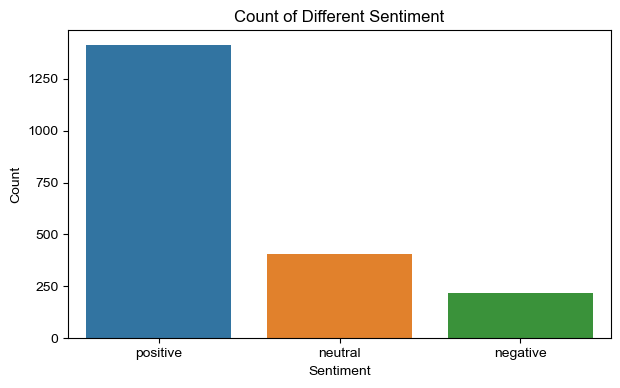

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
ax=sns.countplot(data=df,x='sentiment')
ax.set(xlabel='Sentiment',ylabel="Count",title='Count of Different Sentiment')
sns.set(font_scale=1.5)

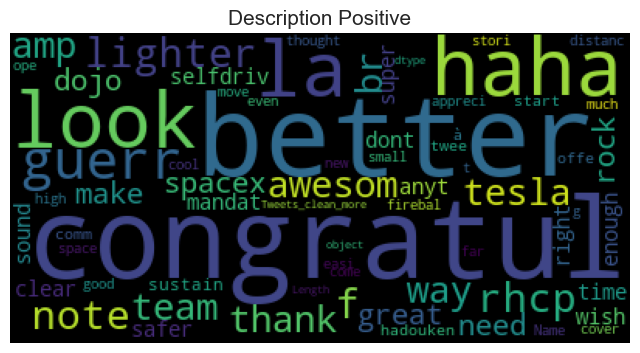

In [54]:
from wordcloud import WordCloud
positive=df[df["sentiment"]=="positive"]
plt.rcParams['figure.figsize']=(8,8)
plt.style.use('fast')
wc=WordCloud(background_color='black').generate(str(positive['Tweets_clean_more']))

plt.title('Description Positive', fontsize=15)
plt.imshow(wc)
plt.axis('off')
plt.show()

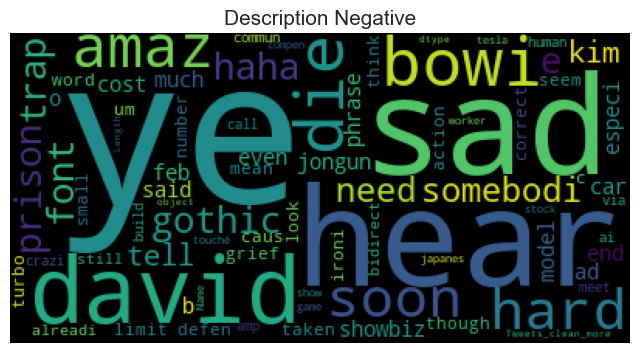

In [55]:
from wordcloud import WordCloud
Negative=df[df["sentiment"]=="negative"]
plt.rcParams['figure.figsize']=(8,8)
plt.style.use('fast')
wc=WordCloud(background_color='black').generate(str(Negative['Tweets_clean_more']))

plt.title('Description Negative', fontsize=15)
plt.imshow(wc)
plt.axis('off')
plt.show()

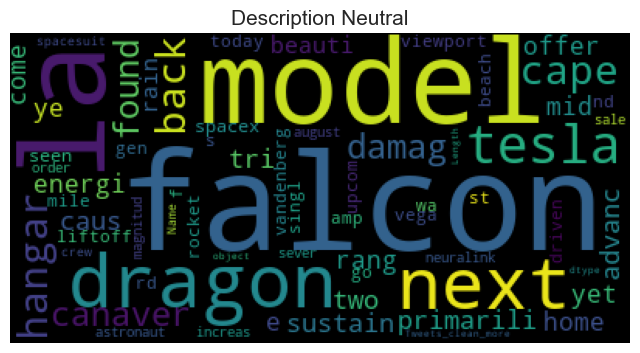

In [56]:
from wordcloud import WordCloud
neutral=df[df["sentiment"]=="neutral"]
plt.rcParams['figure.figsize']=(8,8)
plt.style.use('fast')
wc=WordCloud(background_color='black').generate(str(neutral['Tweets_clean_more']))

plt.title('Description Neutral', fontsize=15)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [57]:
#Save to file
df.to_csv('tweet_cleaned.csv',index=False)